# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# # PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# # FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='ResNext50'

HEIGHT = 137
WIDTH = 236
FACTOR = 0.50
HEIGHT_NEW = int(HEIGHT * FACTOR)
WIDTH_NEW = int(WIDTH * FACTOR)

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
LR = 1e-3
WD = 1e-5
DP = 0.35
HDIM = 1024
outdir = Path('{}_LR{}_WD{}_DP{}_HDIM{}_imagenetch3-simpleaug-fixlr-rs'.format(model_name, LR, WD, DP, HDIM))

TH = 20.0

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 31.4 s, sys: 31 s, total: 1min 2s
Wall time: 6.63 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('indices', 104),
 ('FEATHER_PATH', 103),
 ('PATH', 97),
 ('dirname', 97),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('arch', 59),
 ('model_name', 58),
 ('out', 50),
 ('HDIM', 28),
 ('HEIGHT', 28),
 ('HEIGHT_NEW', 28),
 ('WIDTH', 28),
 ('WIDTH_NEW', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('DP', 24),
 ('FACTOR', 24),
 ('LR', 24),
 ('TH', 24),
 ('WD', 24),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

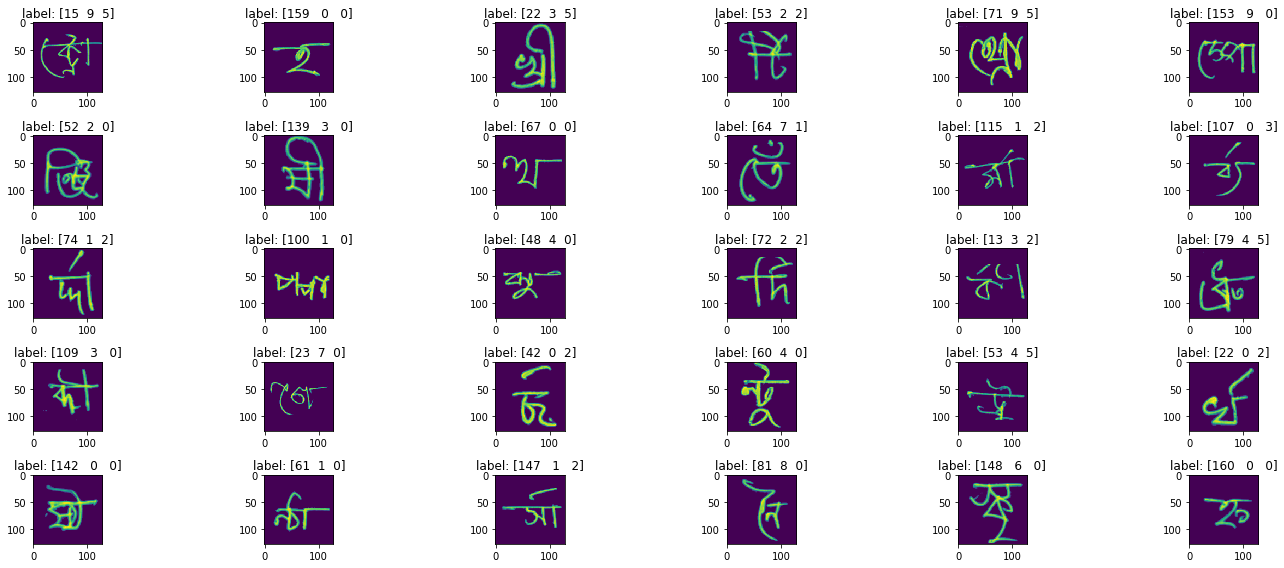

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 10
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = image_size*0.075
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 5 if (xmin > 5) else 0
#     ymin = ymin - 5 if (ymin > 5) else 0
#     xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
#     ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

# def crop_char_image_new(img0, threshold=TH/255., pad=10):
#     ymin,ymax,xmin,xmax = bbox(img0 > threshold)
#     #cropping may cut too much, so we need to add it back
# #     xmin = xmin - 13 if (xmin > 13) else 0
# #     ymin = ymin - 10 if (ymin > 10) else 0
# #     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
# #     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < 28./255.] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [(pad//2,), (pad//2,)], mode='constant')
#     return img

def resize(image, size=(WIDTH_NEW, HEIGHT_NEW)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

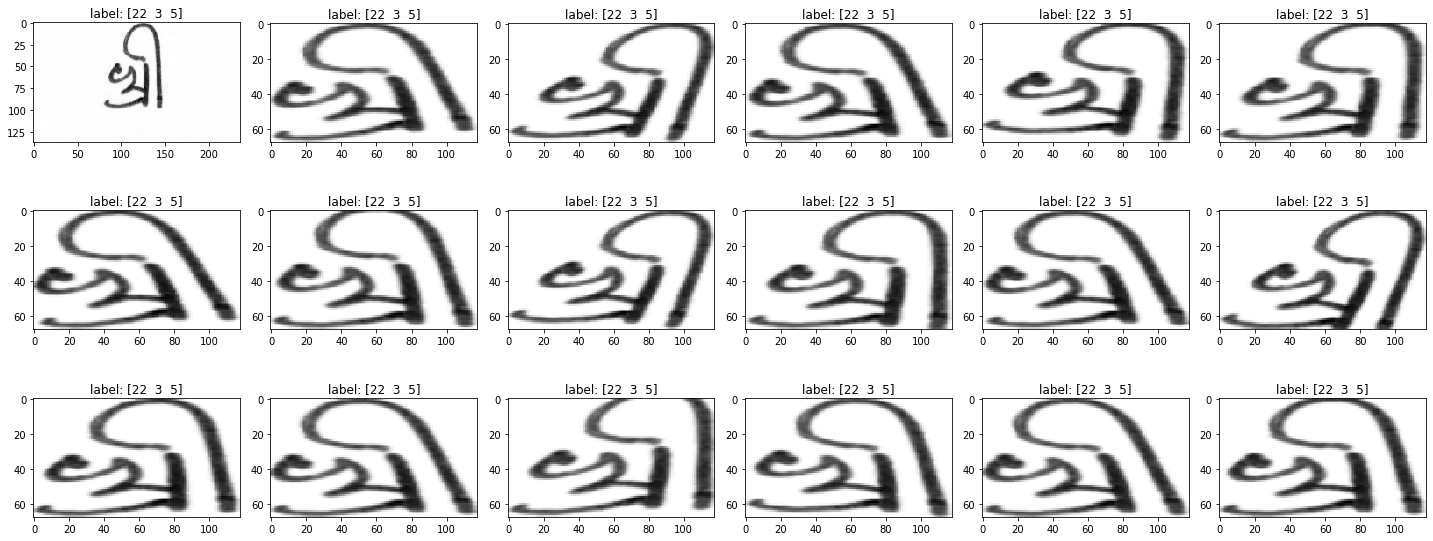

In [19]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

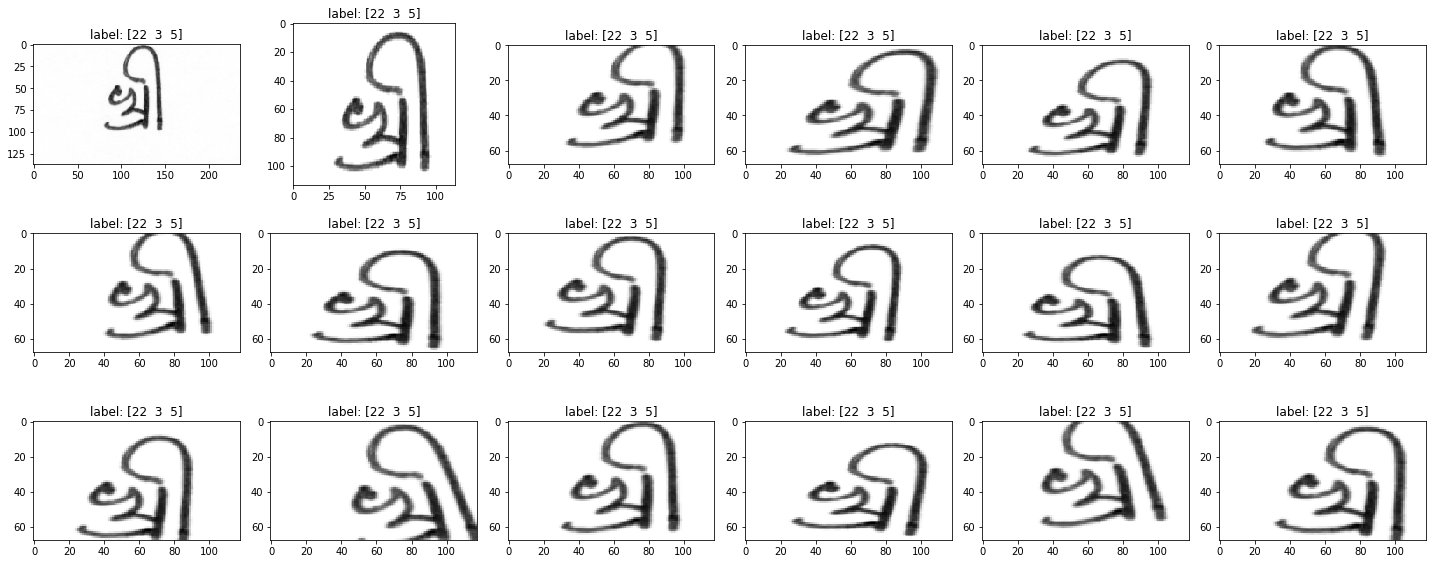

In [20]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
PAD = 20
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    elif i==1:
        ax.imshow(crop_char_image(image), cmap='Greys')
    else:
        ax.imshow(resize((affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

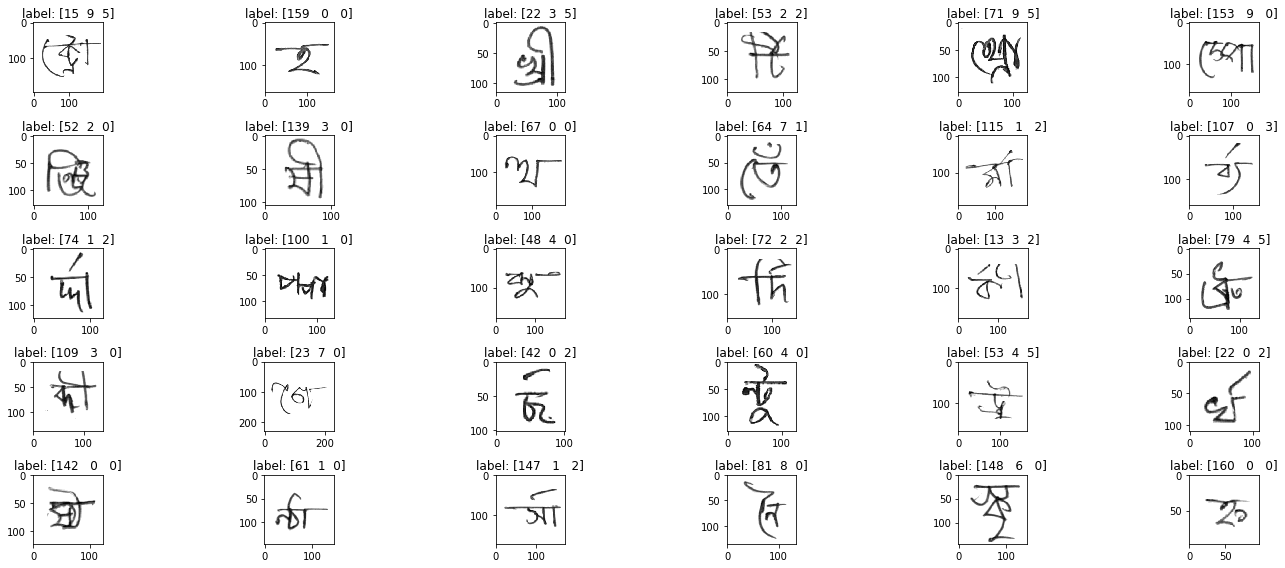

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

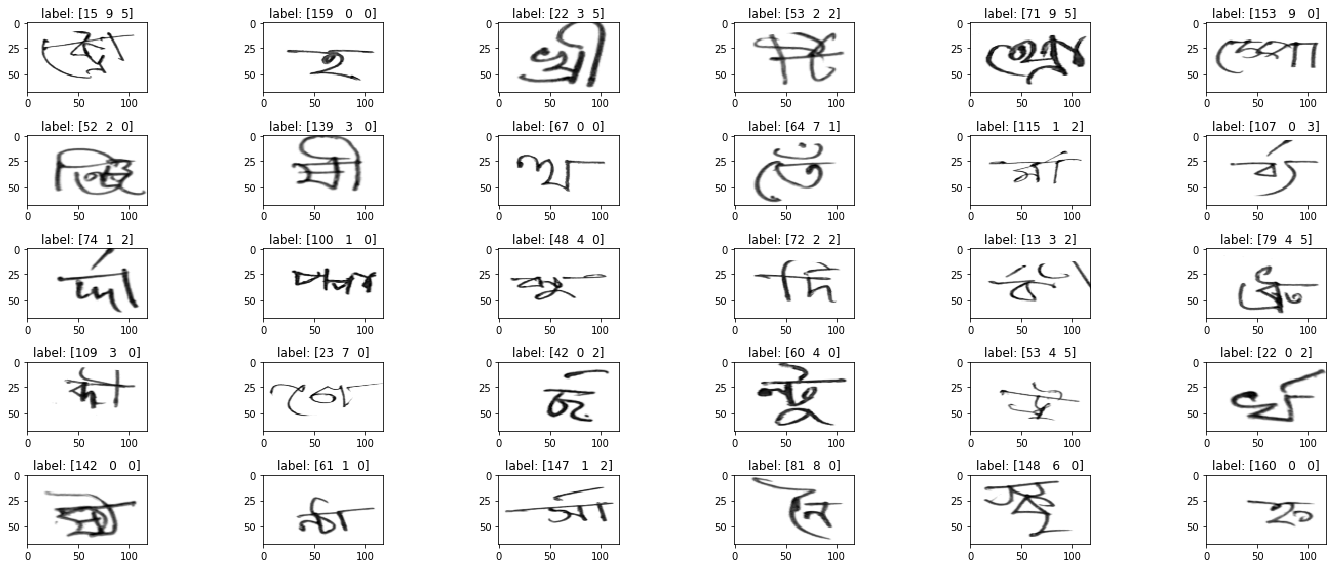

In [22]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize((affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [23]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
#         if self.crop:
#             x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            r = np.random.uniform()
            if r < 0.5:
                x = apply_aug(A.CoarseDropout(max_holes=4, max_height=image_size//8, max_width=image_size//8, p=1.0), x)
            else:
                x = apply_aug(A.Cutout(num_holes=1,  max_h_size=image_size//3, max_w_size=image_size//3, p=1.0),x)  # Deprecated...

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=10,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
            x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [24]:
# train_transform = Transform(
#     size=(image_size, image_size), 
#     sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.4,
#     grid_distortion_ratio=0.1, random_brightness_ratio=0.3,
#     piece_affine_ratio=0.2, ssr_ratio=0.2, elastic_distortion_ratio=0.3) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_transform = Transform(affine=False,
    crop=False, size=(WIDTH_NEW, HEIGHT_NEW)) #threshold=20.,
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

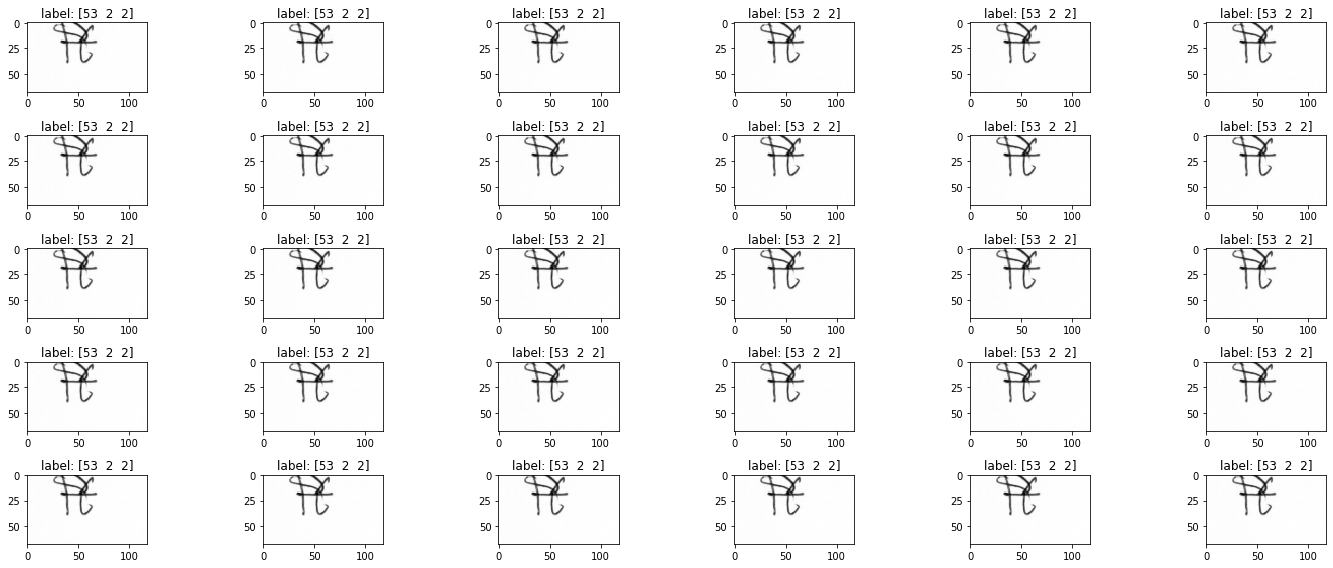

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[3]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

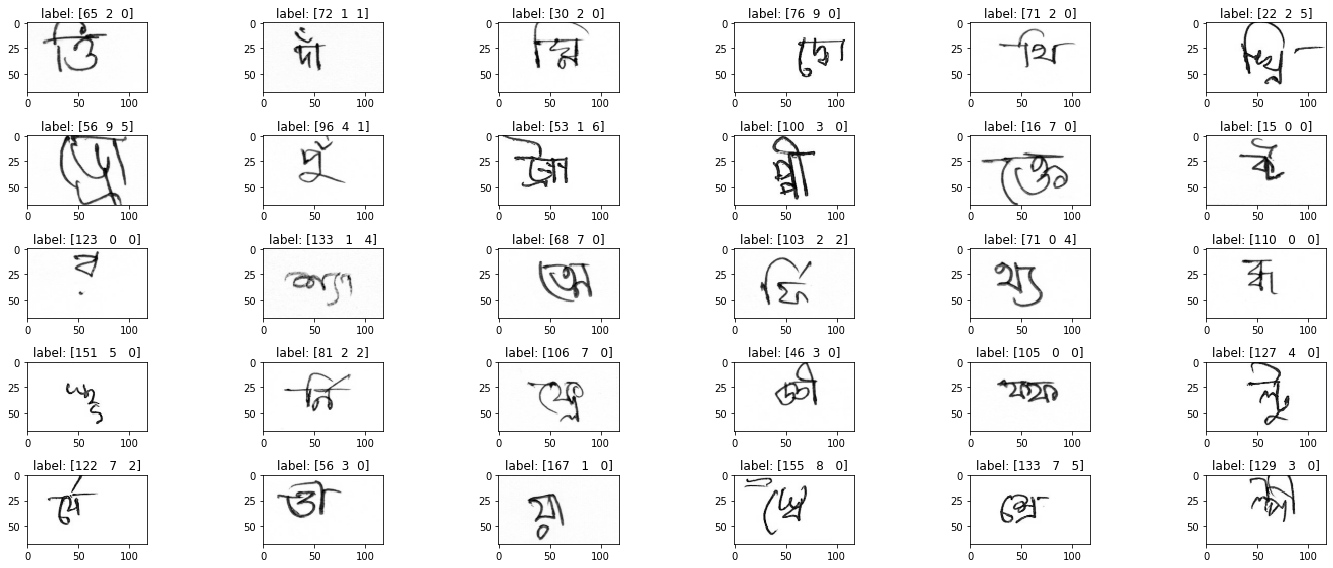

In [26]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i+100]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

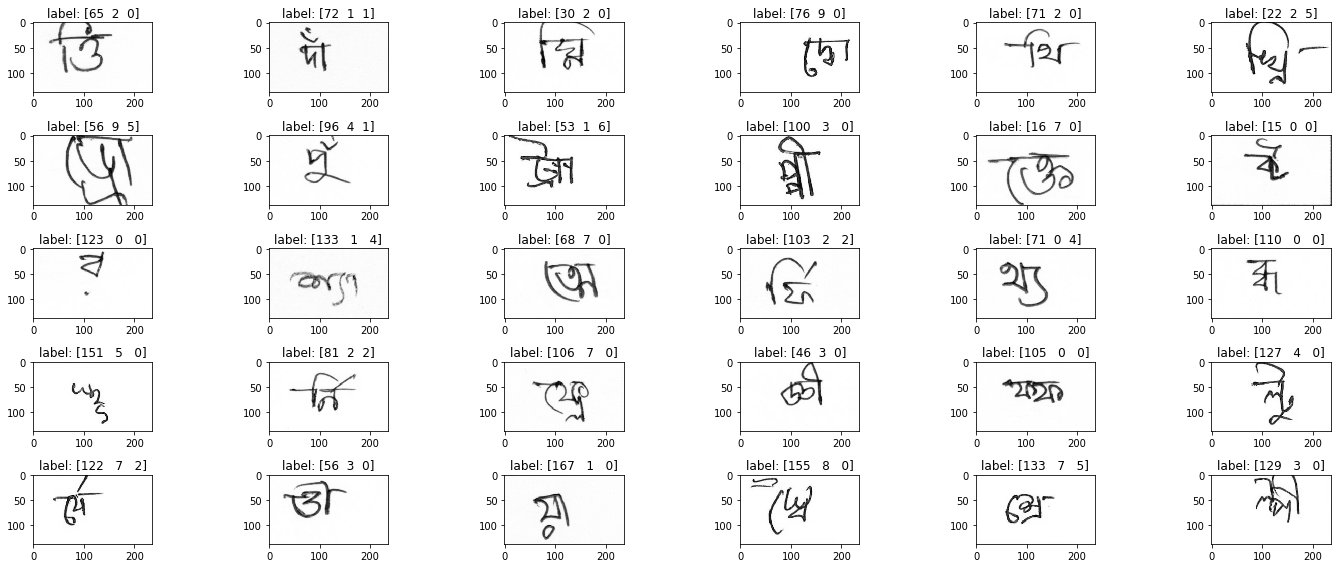

In [27]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i+100]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [28]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [29]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [30]:
a = np.array([2,3])
b = np.array([4,5,6])

In [31]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [32]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [33]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ClassifierNew(nn.Module):
    def __init__(self, inp = 2048, h1=1024, num_class = [1000,1,1], dropout_ratio=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
        self.mp = nn.AdaptiveMaxPool2d(1)
        self.fla = Flatten()
#         self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(dropout_ratio)
        
        self.logit = nn.ModuleList(
            [ nn.Linear(inp*2, c) for c in num_class]
        )
#         self.fc1 = nn.Linear(inp*2, h1)
#         self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
#         self.dropout1 = nn.Dropout(dropout_ratio)
#         self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
#         x = self.bn0(x)
        x = self.dropout0(x)
        logit = [l(x) for l in self.logit]
#         x = F.relu(self.fc1(x))
#         x = self.bn1(x)
#         x = self.dropout1(x)         
#         x = self.fc2(x)
        return logit

In [34]:
# ap = nn.AdaptiveAvgPool2d((1,1))
# mp = nn.AdaptiveMaxPool2d((1,1))
# x = np.random.rand(5,4,4)
# print(x)
# print(ap)
# x1 = torch.nn.functional.adaptive_avg_pool2d(x, (1,1))
# print(x1)

In [35]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [36]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [37]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
import collections
try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

from seresnext import *    

class PretrainedCNN(nn.Module):
    
    def load_pretrain(self, skip=['block0.','logit.'], is_print=True):
        load_pretrain(self, skip, pretrain_file=PRETRAIN_FILE, conversion=CONVERSION, is_print=is_print)
        
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, num_class=[10], use_bn=True,
                 pretrained='imagenet', dropout_ratio=0):
        super(PretrainedCNN, self).__init__()
#         self.conv0 = nn.Conv2d(
#             in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
#         self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
# #         print(self.base_model)
#         names = []
#         for name, child in self.base_model.named_children():
#             names.append(name)
            
#         arch = self.base_model
#         arch = list(arch.children())
#         #saving the weights of the forst conv in w
#         w = arch[0][0].weight
#         #creating new Conv2d to accept 1 channel 
#         arch[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         #substituting weights of newly created Conv2d with w from but we have to take mean
#         #to go from  3 channel to 1
#         arch[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
#         arch = nn.Sequential(OrderedDict([(names[k], arch[k]) for k in range(len(names))]))
# #         print(arch)
#         self.base_model = arch
# #         print("#######################################")
# #         print(self.base_model)
#         activation = F.leaky_relu
#         self.do_pooling = True
#         if self.do_pooling:
#             inch = self.base_model.last_linear.in_features
#         else:
#             inch = None

        e = ResNext50()

        self.block0 = e.block0
        self.block1 = e.block1
        self.block2 = e.block2
        self.block3 = e.block3
        self.block4 = e.block4
        e = None  #dropped
        inch = 2048
        hdim = HDIM
        self.classifer = ClassifierNew(inp = inch, h1=hdim, num_class = num_class, dropout_ratio=dropout_ratio)
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
#         h = self.base_model.layer0(x)
#         h = self.base_model.layer1(h)
#         h = self.base_model.layer2(h)
#         h = self.base_model.layer3(h)
#         h = self.base_model.layer4(h) 

        batch_size,C,H,W = x.shape
        if (H,W) !=(64,112):
             x = F.interpolate(x,size=(64,112), mode='bilinear',align_corners=False)

        x = x.repeat(1,3,1,1)
        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        h = self.classifer(x)

        return h

In [38]:
def print_base_layers(predictor):
    print("base model layer names::")
    for name, child in predictor.base_model.named_children():
        print(name)
        
def print_base_grad_status(predictor):
    print("base model grad status::")
    for name, child in predictor.base_model.named_children():
        print(name)
        for param in child.parameters():
            print(param.requires_grad)

In [39]:
# print_grad_status(predictortmp)

In [40]:
def frozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        if name in ['layer0','layer1','layer2','layer3']:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False
        else:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True

In [41]:
def unfrozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        for param in child.parameters():
            param.requires_grad = True

In [42]:
# frozen_basiclayers(predictortmp)
# print_grad_status(predictortmp)

In [43]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [44]:
predictortmp = PretrainedCNN(in_channels=1, num_class=[n_grapheme, n_vowel, n_consonant], model_name=model_name, pretrained="imagenet")
for name, child in predictortmp.named_children():
    print(name)
# print_base_layers(predictortmp)

block0
block1
block2
block3
block4
classifer


In [45]:
# def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
#     base_params = list(map(id, classifier.predictor.base_model.parameters()))
#     fast_learned_params = filter(lambda p: id(p) not in base_params, 
#                                  classifier.parameters())
# #     print("base_params len:", len(base_params))
# #     print("fast_learned_params len:", len(list(fast_learned_params)))
#     lr_100 = max(learning_rate/100, 1e-6)
#     lr_10 = max(learning_rate/10, 5e-6)
#     optimizer = torch.optim.Adam(
#     [
#         dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer4.parameters(), lr=lr_10),        
#         dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=lr_10),
#         {'params': fast_learned_params},
#     ], lr = learning_rate, weight_decay=weight_decay)
    
#     return optimizer

In [46]:
# def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
#     base_params = list(map(id, classifier.predictor.base_model.parameters()))
#     fast_learned_params = filter(lambda p: id(p) not in base_params, 
#                                  classifier.parameters())
# #     print("base_params len:", len(base_params))
# #     print("fast_learned_params len:", len(list(fast_learned_params)))
#     lr_100 = max(learning_rate/100, 1e-7)
#     lr_10 = max(learning_rate/10, 1e-7)
#     optimizer = torch.optim.Adam(
#     [
#         dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer4.parameters(), lr=learning_rate),        
#         dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=learning_rate),
#         dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=learning_rate),
#         {'params': fast_learned_params},
#     ], lr = learning_rate, weight_decay=weight_decay)
    
#     return optimizer

In [47]:
def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
    base_params = list(map(id, classifier.predictor.parameters()))
    fast_learned_params = filter(lambda p: id(p) not in base_params, 
                                 classifier.parameters())
#     print("base_params len:", len(base_params))
#     print("fast_learned_params len:", len(list(fast_learned_params)))
    lr_100 = max(learning_rate/100, 1e-7)
    lr_10 = max(learning_rate/10, 1e-7)
    optimizer = torch.optim.Adam(
    [
        dict(params=classifier.predictor.block0.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block1.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block2.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block3.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block4.parameters(), lr=learning_rate),
        {'params': fast_learned_params},
    ], lr = learning_rate, weight_decay=weight_decay)
    
    return optimizer

## Classifier

In [48]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, list):
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = 2*F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [49]:
# classifiertmp = BengaliClassifier(predictortmp).to(device)
# # for name, child in classifiertmp.named_children():
# #     print(name)
# # optimizertmp = get_optimizer_adam(classifiertmp)
# # print(optimizertmp)

# ctmp_params = list(map(id, classifiertmp.parameters()))
# print(len(ctmp_params))

# pbtmp_params = list(map(id, predictortmp.base_model.parameters()))
# print(len(pbtmp_params))

# pcftmp_params = list(map(id, predictortmp.classifer.parameters()))
# print(len(pcftmp_params))

# opt_tmp = get_optimizer_adam(classifiertmp)
# print(opt_tmp)

<a id="train"></a>
# Training code


In [50]:
# --- Model ---
device = torch.device(device)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[-1]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

## prepare data

In [51]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [52]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [53]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [54]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    if not isinstance(pred_y, list):
        pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [55]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [56]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    return metrics_total, n_train_call

In [57]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
        
        schedule_lr(metrics_total)   
        return metrics_total


## Train


In [58]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [59]:
def save_params(outdir, k, img_size, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': model_name,
               'learning_rate': LR,
               'weight_decay': WD,
               'dropout_ratio': DP,
               'hidden_dim':HDIM
              }
             )

In [60]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 5
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, num_class=[n_grapheme, n_vowel, n_consonant], model_name=model_name, pretrained="imagenet", dropout_ratio=DP)
    predictor.load_pretrain(is_print=False)
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)
    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=LR, weight_decay=WD)
#     optimizer = get_optimizer_adam(classifier, learning_rate=LR, weight_decay=WD)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-7)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=False, size=(WIDTH_NEW, HEIGHT_NEW)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

	load pretrain_file: se_resnext50_32x4d-a260b3a4.pth

len(pretrain_state_dict.keys()) = 331
len(state_dict.keys())          = 400
loaded    = 324

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  2.264019 train/loss_grapheme  1.775218 train/loss_vowel  0.261736 train/loss_consonant  0.227065 train/acc_grapheme  0.767489 train/acc_vowel  0.920602 train/acc_consonant  0.929664 train/recall  0.779511 val/loss  1.087739 val/loss_grapheme  0.836280 val/loss_vowel  0.136300 val/loss_consonant  0.115159 val/acc_grapheme  0.882792 val/acc_vowel  0.960765 val/acc_consonant  0.967561 val/recall  0.878625 lr  0.001000 elapsed_time  1238.607984 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  0.917232 train/loss_grapheme  0.695049 train/loss_vowel  0.114614 train/loss_consonant  0.107570 train/acc_grapheme  0.902148 train/acc_vowel  0.969136 train/acc_consonant  0.969005 train/recall  0.897717 val/loss  0.816318 val/loss_grapheme  0.611114 val/loss_vowel  0.100534 val/loss_consonant  0.104670 val/acc_grapheme  0.917297 val/acc_vowel  0.971993 val/acc_consonant  0.969827 val/recall  0.914471 lr  0.001000 elapsed_time  2472.904754 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  0.745845 train/loss_grapheme  0.561659 train/loss_vowel  0.095449 train/loss_consonant  0.088737 train/acc_grapheme  0.920565 train/acc_vowel  0.974345 train/acc_consonant  0.974507 train/recall  0.915534 val/loss  0.730887 val/loss_grapheme  0.553407 val/loss_vowel  0.087886 val/loss_consonant  0.089594 val/acc_grapheme  0.925513 val/acc_vowel  0.977445 val/acc_consonant  0.976300 val/recall  0.922551 lr  0.001000 elapsed_time  3710.994054 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  0.638369 train/loss_grapheme  0.476280 train/loss_vowel  0.083868 train/loss_consonant  0.078220 train/acc_grapheme  0.931469 train/acc_vowel  0.978279 train/acc_consonant  0.977843 train/recall  0.925997 val/loss  0.647948 val/loss_grapheme  0.491632 val/loss_vowel  0.082568 val/loss_consonant  0.073748 val/acc_grapheme  0.933878 val/acc_vowel  0.978839 val/acc_consonant  0.978864 val/recall  0.930160 lr  0.001000 elapsed_time  4945.997644 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  0.561054 train/loss_grapheme  0.418144 train/loss_vowel  0.073475 train/loss_consonant  0.069435 train/acc_grapheme  0.939498 train/acc_vowel  0.980613 train/acc_consonant  0.980600 train/recall  0.934961 val/loss  0.626391 val/loss_grapheme  0.476278 val/loss_vowel  0.075050 val/loss_consonant  0.075063 val/acc_grapheme  0.934674 val/acc_vowel  0.981229 val/acc_consonant  0.979810 val/recall  0.931128 lr  0.001000 elapsed_time  6183.169025 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  0.489486 train/loss_grapheme  0.360773 train/loss_vowel  0.065973 train/loss_consonant  0.062740 train/acc_grapheme  0.947334 train/acc_vowel  0.982779 train/acc_consonant  0.982287 train/recall  0.941732 val/loss  0.628970 val/loss_grapheme  0.478788 val/loss_vowel  0.076650 val/loss_consonant  0.073531 val/acc_grapheme  0.937264 val/acc_vowel  0.980233 val/acc_consonant  0.979536 val/recall  0.934117 lr  0.001000 elapsed_time  7414.885552 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  0.444633 train/loss_grapheme  0.325726 train/loss_vowel  0.062404 train/loss_consonant  0.056504 train/acc_grapheme  0.951995 train/acc_vowel  0.984266 train/acc_consonant  0.984030 train/recall  0.947365 val/loss  0.579359 val/loss_grapheme  0.444737 val/loss_vowel  0.068714 val/loss_consonant  0.065908 val/acc_grapheme  0.939554 val/acc_vowel  0.982698 val/acc_consonant  0.982648 val/recall  0.939058 lr  0.001000 elapsed_time  8651.120285 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.403144 train/loss_grapheme  0.292873 train/loss_vowel  0.058088 train/loss_consonant  0.052184 train/acc_grapheme  0.956377 train/acc_vowel  0.985374 train/acc_consonant  0.985393 train/recall  0.952295 val/loss  0.559458 val/loss_grapheme  0.424134 val/loss_vowel  0.064481 val/loss_consonant  0.070843 val/acc_grapheme  0.943985 val/acc_vowel  0.984590 val/acc_consonant  0.981602 val/recall  0.940967 lr  0.001000 elapsed_time  9891.415099 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.367189 train/loss_grapheme  0.266537 train/loss_vowel  0.051348 train/loss_consonant  0.049304 train/acc_grapheme  0.960111 train/acc_vowel  0.986868 train/acc_consonant  0.986339 train/recall  0.955664 val/loss  0.611919 val/loss_grapheme  0.472479 val/loss_vowel  0.070236 val/loss_consonant  0.069205 val/acc_grapheme  0.938334 val/acc_vowel  0.983046 val/acc_consonant  0.982225 val/recall  0.935950 lr  0.001000 elapsed_time  11130.909190 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.342084 train/loss_grapheme  0.245311 train/loss_vowel  0.050568 train/loss_consonant  0.046205 train/acc_grapheme  0.962881 train/acc_vowel  0.987503 train/acc_consonant  0.987372 train/recall  0.958175 val/loss  0.627581 val/loss_grapheme  0.480809 val/loss_vowel  0.072925 val/loss_consonant  0.073848 val/acc_grapheme  0.939380 val/acc_vowel  0.981801 val/acc_consonant  0.979934 val/recall  0.938512 lr  0.001000 elapsed_time  12363.038166 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.316858 train/loss_grapheme  0.226508 train/loss_vowel  0.047329 train/loss_consonant  0.043021 train/acc_grapheme  0.965769 train/acc_vowel  0.987982 train/acc_consonant  0.988125 train/recall  0.961247 val/loss  0.583700 val/loss_grapheme  0.439148 val/loss_vowel  0.073108 val/loss_consonant  0.071445 val/acc_grapheme  0.944458 val/acc_vowel  0.983793 val/acc_consonant  0.982324 val/recall  0.941388 lr  0.001000 elapsed_time  13593.849111 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.290804 train/loss_grapheme  0.206642 train/loss_vowel  0.043981 train/loss_consonant  0.040181 train/acc_grapheme  0.968159 train/acc_vowel  0.988953 train/acc_consonant  0.988946 train/recall  0.964050 val/loss  0.576799 val/loss_grapheme  0.439980 val/loss_vowel  0.067768 val/loss_consonant  0.069052 val/acc_grapheme  0.947047 val/acc_vowel  0.985810 val/acc_consonant  0.983021 val/recall  0.944892 lr  0.001000 elapsed_time  14831.141657 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  0.279014 train/loss_grapheme  0.198221 train/loss_vowel  0.041260 train/loss_consonant  0.039533 train/acc_grapheme  0.969634 train/acc_vowel  0.989351 train/acc_consonant  0.988828 train/recall  0.965050 val/loss  0.589039 val/loss_grapheme  0.450463 val/loss_vowel  0.072871 val/loss_consonant  0.065706 val/acc_grapheme  0.945579 val/acc_vowel  0.983420 val/acc_consonant  0.983146 val/recall  0.943605 lr  0.001000 elapsed_time  16061.820676 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  0.260784 train/loss_grapheme  0.183113 train/loss_vowel  0.040427 train/loss_consonant  0.037245 train/acc_grapheme  0.971507 train/acc_vowel  0.989619 train/acc_consonant  0.989706 train/recall  0.967374 val/loss  0.575977 val/loss_grapheme  0.438553 val/loss_vowel  0.070281 val/loss_consonant  0.067143 val/acc_grapheme  0.947545 val/acc_vowel  0.984590 val/acc_consonant  0.983295 val/recall  0.946015 lr  0.001000 elapsed_time  17292.380852 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.167061 train/loss_grapheme  0.111972 train/loss_vowel  0.029019 train/loss_consonant  0.026071 train/acc_grapheme  0.981969 train/acc_vowel  0.992612 train/acc_consonant  0.993036 train/recall  0.978465 val/loss  0.599682 val/loss_grapheme  0.457379 val/loss_vowel  0.069942 val/loss_consonant  0.072362 val/acc_grapheme  0.948491 val/acc_vowel  0.986034 val/acc_consonant  0.983992 val/recall  0.945090 lr  0.000700 elapsed_time  18524.768539 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  0.155832 train/loss_grapheme  0.104958 train/loss_vowel  0.027006 train/loss_consonant  0.023868 train/acc_grapheme  0.983077 train/acc_vowel  0.992818 train/acc_consonant  0.993602 train/recall  0.979849 val/loss  0.551411 val/loss_grapheme  0.417595 val/loss_vowel  0.064640 val/loss_consonant  0.069177 val/acc_grapheme  0.952574 val/acc_vowel  0.986009 val/acc_consonant  0.984640 val/recall  0.950021 lr  0.000700 elapsed_time  19751.927586 mode 011 


100%|██████████| 419/419 [01:28<00:00,  4.74it/s]


epoch     16 train/loss  0.151399 train/loss_grapheme  0.101363 train/loss_vowel  0.026345 train/loss_consonant  0.023690 train/acc_grapheme  0.983756 train/acc_vowel  0.993253 train/acc_consonant  0.993471 train/recall  0.980835 val/loss  0.586750 val/loss_grapheme  0.443197 val/loss_vowel  0.070219 val/loss_consonant  0.073334 val/acc_grapheme  0.951155 val/acc_vowel  0.986880 val/acc_consonant  0.984590 val/recall  0.949212 lr  0.000700 elapsed_time  20982.999112 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  0.138712 train/loss_grapheme  0.092074 train/loss_vowel  0.023898 train/loss_consonant  0.022740 train/acc_grapheme  0.985106 train/acc_vowel  0.993645 train/acc_consonant  0.993558 train/recall  0.981826 val/loss  0.648816 val/loss_grapheme  0.499712 val/loss_vowel  0.073794 val/loss_consonant  0.075310 val/acc_grapheme  0.950558 val/acc_vowel  0.985685 val/acc_consonant  0.984515 val/recall  0.950012 lr  0.000700 elapsed_time  22214.051407 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.132848 train/loss_grapheme  0.086806 train/loss_vowel  0.024639 train/loss_consonant  0.021403 train/acc_grapheme  0.985909 train/acc_vowel  0.993328 train/acc_consonant  0.993969 train/recall  0.982923 val/loss  0.598657 val/loss_grapheme  0.457911 val/loss_vowel  0.069433 val/loss_consonant  0.071313 val/acc_grapheme  0.951031 val/acc_vowel  0.986507 val/acc_consonant  0.984540 val/recall  0.949773 lr  0.000700 elapsed_time  23439.267673 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  0.135494 train/loss_grapheme  0.091004 train/loss_vowel  0.022871 train/loss_consonant  0.021620 train/acc_grapheme  0.985542 train/acc_vowel  0.993807 train/acc_consonant  0.994038 train/recall  0.982888 val/loss  0.649505 val/loss_grapheme  0.496655 val/loss_vowel  0.074410 val/loss_consonant  0.078440 val/acc_grapheme  0.948915 val/acc_vowel  0.985486 val/acc_consonant  0.984465 val/recall  0.946488 lr  0.000700 elapsed_time  24668.346597 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  0.121623 train/loss_grapheme  0.080919 train/loss_vowel  0.021318 train/loss_consonant  0.019386 train/acc_grapheme  0.986861 train/acc_vowel  0.994268 train/acc_consonant  0.994411 train/recall  0.983930 val/loss  0.630906 val/loss_grapheme  0.472537 val/loss_vowel  0.078154 val/loss_consonant  0.080215 val/acc_grapheme  0.950956 val/acc_vowel  0.985386 val/acc_consonant  0.984216 val/recall  0.948392 lr  0.000700 elapsed_time  25895.438724 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  0.118111 train/loss_grapheme  0.078254 train/loss_vowel  0.020250 train/loss_consonant  0.019607 train/acc_grapheme  0.987303 train/acc_vowel  0.994492 train/acc_consonant  0.994262 train/recall  0.984377 val/loss  0.648512 val/loss_grapheme  0.494514 val/loss_vowel  0.076640 val/loss_consonant  0.077358 val/acc_grapheme  0.951155 val/acc_vowel  0.986034 val/acc_consonant  0.984640 val/recall  0.948825 lr  0.000700 elapsed_time  27126.140675 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.070861 train/loss_grapheme  0.044049 train/loss_vowel  0.014092 train/loss_consonant  0.012720 train/acc_grapheme  0.992662 train/acc_vowel  0.996141 train/acc_consonant  0.996098 train/recall  0.990501 val/loss  0.650009 val/loss_grapheme  0.498113 val/loss_vowel  0.074175 val/loss_consonant  0.077721 val/acc_grapheme  0.953719 val/acc_vowel  0.987627 val/acc_consonant  0.985287 val/recall  0.951427 lr  0.000490 elapsed_time  28353.929078 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  0.067231 train/loss_grapheme  0.041931 train/loss_vowel  0.013727 train/loss_consonant  0.011572 train/acc_grapheme  0.993210 train/acc_vowel  0.995998 train/acc_consonant  0.996627 train/recall  0.990934 val/loss  0.680996 val/loss_grapheme  0.515516 val/loss_vowel  0.081359 val/loss_consonant  0.084121 val/acc_grapheme  0.953869 val/acc_vowel  0.987029 val/acc_consonant  0.985362 val/recall  0.950884 lr  0.000490 elapsed_time  29583.661450 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.065658 train/loss_grapheme  0.041524 train/loss_vowel  0.012914 train/loss_consonant  0.011220 train/acc_grapheme  0.993191 train/acc_vowel  0.996110 train/acc_consonant  0.996813 train/recall  0.991298 val/loss  0.652797 val/loss_grapheme  0.494955 val/loss_vowel  0.077067 val/loss_consonant  0.080775 val/acc_grapheme  0.954865 val/acc_vowel  0.986556 val/acc_consonant  0.985386 val/recall  0.951281 lr  0.000490 elapsed_time  30810.509023 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  0.064174 train/loss_grapheme  0.040399 train/loss_vowel  0.012227 train/loss_consonant  0.011548 train/acc_grapheme  0.993247 train/acc_vowel  0.996347 train/acc_consonant  0.996602 train/recall  0.991491 val/loss  0.666878 val/loss_grapheme  0.509203 val/loss_vowel  0.078067 val/loss_consonant  0.079609 val/acc_grapheme  0.954740 val/acc_vowel  0.987179 val/acc_consonant  0.985486 val/recall  0.952776 lr  0.000490 elapsed_time  32040.568486 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.062776 train/loss_grapheme  0.038745 train/loss_vowel  0.012052 train/loss_consonant  0.011979 train/acc_grapheme  0.993813 train/acc_vowel  0.996627 train/acc_consonant  0.996303 train/recall  0.991745 val/loss  0.683178 val/loss_grapheme  0.516259 val/loss_vowel  0.083667 val/loss_consonant  0.083252 val/acc_grapheme  0.955089 val/acc_vowel  0.986432 val/acc_consonant  0.986233 val/recall  0.952951 lr  0.000490 elapsed_time  33268.971144 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  0.062329 train/loss_grapheme  0.041172 train/loss_vowel  0.011150 train/loss_consonant  0.010007 train/acc_grapheme  0.993347 train/acc_vowel  0.996465 train/acc_consonant  0.996975 train/recall  0.991632 val/loss  0.683752 val/loss_grapheme  0.510697 val/loss_vowel  0.085852 val/loss_consonant  0.087202 val/acc_grapheme  0.954541 val/acc_vowel  0.986581 val/acc_consonant  0.985088 val/recall  0.952270 lr  0.000490 elapsed_time  34498.626774 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  0.036229 train/loss_grapheme  0.022052 train/loss_vowel  0.006949 train/loss_consonant  0.007228 train/acc_grapheme  0.996409 train/acc_vowel  0.997865 train/acc_consonant  0.997797 train/recall  0.995047 val/loss  0.696403 val/loss_grapheme  0.523422 val/loss_vowel  0.085370 val/loss_consonant  0.087612 val/acc_grapheme  0.956782 val/acc_vowel  0.987478 val/acc_consonant  0.985859 val/recall  0.954603 lr  0.000343 elapsed_time  35719.289207 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  0.031383 train/loss_grapheme  0.019167 train/loss_vowel  0.006760 train/loss_consonant  0.005456 train/acc_grapheme  0.996938 train/acc_vowel  0.997909 train/acc_consonant  0.998232 train/recall  0.995549 val/loss  0.761621 val/loss_grapheme  0.570987 val/loss_vowel  0.090997 val/loss_consonant  0.099638 val/acc_grapheme  0.955562 val/acc_vowel  0.987453 val/acc_consonant  0.985785 val/recall  0.953307 lr  0.000343 elapsed_time  36948.698174 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  0.035088 train/loss_grapheme  0.022363 train/loss_vowel  0.006082 train/loss_consonant  0.006643 train/acc_grapheme  0.996315 train/acc_vowel  0.998077 train/acc_consonant  0.997909 train/recall  0.995169 val/loss  0.722016 val/loss_grapheme  0.540822 val/loss_vowel  0.091695 val/loss_consonant  0.089498 val/acc_grapheme  0.956234 val/acc_vowel  0.987751 val/acc_consonant  0.986283 val/recall  0.953948 lr  0.000343 elapsed_time  38176.479319 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  0.030808 train/loss_grapheme  0.019146 train/loss_vowel  0.006047 train/loss_consonant  0.005616 train/acc_grapheme  0.996907 train/acc_vowel  0.998183 train/acc_consonant  0.998320 train/recall  0.996000 val/loss  0.761211 val/loss_grapheme  0.571541 val/loss_vowel  0.094163 val/loss_consonant  0.095507 val/acc_grapheme  0.957479 val/acc_vowel  0.987378 val/acc_consonant  0.985561 val/recall  0.955164 lr  0.000343 elapsed_time  39402.942638 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  0.033925 train/loss_grapheme  0.021800 train/loss_vowel  0.006229 train/loss_consonant  0.005896 train/acc_grapheme  0.996403 train/acc_vowel  0.998102 train/acc_consonant  0.998083 train/recall  0.995296 val/loss  0.773195 val/loss_grapheme  0.586684 val/loss_vowel  0.092328 val/loss_consonant  0.094184 val/acc_grapheme  0.955512 val/acc_vowel  0.987353 val/acc_consonant  0.985934 val/recall  0.953520 lr  0.000343 elapsed_time  40628.205406 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  0.032707 train/loss_grapheme  0.020283 train/loss_vowel  0.006279 train/loss_consonant  0.006145 train/acc_grapheme  0.996652 train/acc_vowel  0.998152 train/acc_consonant  0.998058 train/recall  0.995609 val/loss  0.752003 val/loss_grapheme  0.561301 val/loss_vowel  0.097222 val/loss_consonant  0.093481 val/acc_grapheme  0.957703 val/acc_vowel  0.987776 val/acc_consonant  0.987079 val/recall  0.955908 lr  0.000343 elapsed_time  41853.476829 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  0.017459 train/loss_grapheme  0.010553 train/loss_vowel  0.004071 train/loss_consonant  0.002835 train/acc_grapheme  0.998313 train/acc_vowel  0.998712 train/acc_consonant  0.999098 train/recall  0.997709 val/loss  0.771428 val/loss_grapheme  0.577441 val/loss_vowel  0.094990 val/loss_consonant  0.098998 val/acc_grapheme  0.957255 val/acc_vowel  0.987901 val/acc_consonant  0.986681 val/recall  0.955429 lr  0.000240 elapsed_time  43083.017166 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  0.019590 train/loss_grapheme  0.011876 train/loss_vowel  0.003648 train/loss_consonant  0.004066 train/acc_grapheme  0.998239 train/acc_vowel  0.998929 train/acc_consonant  0.998662 train/recall  0.997552 val/loss  0.785513 val/loss_grapheme  0.590437 val/loss_vowel  0.096363 val/loss_consonant  0.098713 val/acc_grapheme  0.957279 val/acc_vowel  0.987527 val/acc_consonant  0.986880 val/recall  0.954609 lr  0.000240 elapsed_time  44306.136682 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  0.019767 train/loss_grapheme  0.012952 train/loss_vowel  0.003699 train/loss_consonant  0.003116 train/acc_grapheme  0.997934 train/acc_vowel  0.998849 train/acc_consonant  0.998948 train/recall  0.997336 val/loss  0.781568 val/loss_grapheme  0.577062 val/loss_vowel  0.100278 val/loss_consonant  0.104228 val/acc_grapheme  0.958126 val/acc_vowel  0.988175 val/acc_consonant  0.986208 val/recall  0.955713 lr  0.000240 elapsed_time  45532.445280 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  0.017097 train/loss_grapheme  0.011086 train/loss_vowel  0.003016 train/loss_consonant  0.002995 train/acc_grapheme  0.998332 train/acc_vowel  0.999035 train/acc_consonant  0.999060 train/recall  0.997725 val/loss  0.810024 val/loss_grapheme  0.590804 val/loss_vowel  0.107366 val/loss_consonant  0.111853 val/acc_grapheme  0.956732 val/acc_vowel  0.987353 val/acc_consonant  0.986432 val/recall  0.955058 lr  0.000240 elapsed_time  46758.935607 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  0.018478 train/loss_grapheme  0.011967 train/loss_vowel  0.003493 train/loss_consonant  0.003017 train/acc_grapheme  0.998058 train/acc_vowel  0.998867 train/acc_consonant  0.999085 train/recall  0.997403 val/loss  0.821482 val/loss_grapheme  0.603304 val/loss_vowel  0.101856 val/loss_consonant  0.116321 val/acc_grapheme  0.955661 val/acc_vowel  0.987278 val/acc_consonant  0.985859 val/recall  0.952867 lr  0.000240 elapsed_time  47987.317040 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  0.019851 train/loss_grapheme  0.012216 train/loss_vowel  0.004257 train/loss_consonant  0.003379 train/acc_grapheme  0.998058 train/acc_vowel  0.998774 train/acc_consonant  0.998979 train/recall  0.997242 val/loss  0.806145 val/loss_grapheme  0.592289 val/loss_vowel  0.103921 val/loss_consonant  0.109935 val/acc_grapheme  0.957977 val/acc_vowel  0.987029 val/acc_consonant  0.986059 val/recall  0.954939 lr  0.000240 elapsed_time  49209.645083 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  0.010476 train/loss_grapheme  0.006247 train/loss_vowel  0.002320 train/loss_consonant  0.001909 train/acc_grapheme  0.999054 train/acc_vowel  0.999328 train/acc_consonant  0.999415 train/recall  0.998664 val/loss  0.809069 val/loss_grapheme  0.590454 val/loss_vowel  0.104039 val/loss_consonant  0.114576 val/acc_grapheme  0.958873 val/acc_vowel  0.988075 val/acc_consonant  0.986407 val/recall  0.956745 lr  0.000168 elapsed_time  50434.353674 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  0.008825 train/loss_grapheme  0.006229 train/loss_vowel  0.001509 train/loss_consonant  0.001086 train/acc_grapheme  0.999104 train/acc_vowel  0.999521 train/acc_consonant  0.999633 train/recall  0.998809 val/loss  0.856533 val/loss_grapheme  0.627241 val/loss_vowel  0.106976 val/loss_consonant  0.122316 val/acc_grapheme  0.958051 val/acc_vowel  0.988274 val/acc_consonant  0.985934 val/recall  0.956170 lr  0.000168 elapsed_time  51661.764540 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  0.008999 train/loss_grapheme  0.005206 train/loss_vowel  0.001765 train/loss_consonant  0.002029 train/acc_grapheme  0.999241 train/acc_vowel  0.999496 train/acc_consonant  0.999378 train/recall  0.998824 val/loss  0.854123 val/loss_grapheme  0.622743 val/loss_vowel  0.108214 val/loss_consonant  0.123167 val/acc_grapheme  0.958225 val/acc_vowel  0.988224 val/acc_consonant  0.985909 val/recall  0.956240 lr  0.000168 elapsed_time  52885.897757 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  0.009915 train/loss_grapheme  0.006406 train/loss_vowel  0.001620 train/loss_consonant  0.001889 train/acc_grapheme  0.998961 train/acc_vowel  0.999490 train/acc_consonant  0.999409 train/recall  0.998550 val/loss  0.854864 val/loss_grapheme  0.622918 val/loss_vowel  0.113309 val/loss_consonant  0.118636 val/acc_grapheme  0.958898 val/acc_vowel  0.988299 val/acc_consonant  0.987005 val/recall  0.956498 lr  0.000168 elapsed_time  54113.686409 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  0.009117 train/loss_grapheme  0.005665 train/loss_vowel  0.001839 train/loss_consonant  0.001613 train/acc_grapheme  0.999228 train/acc_vowel  0.999403 train/acc_consonant  0.999452 train/recall  0.998730 val/loss  0.838692 val/loss_grapheme  0.608540 val/loss_vowel  0.112026 val/loss_consonant  0.118126 val/acc_grapheme  0.959645 val/acc_vowel  0.988548 val/acc_consonant  0.986681 val/recall  0.957208 lr  0.000168 elapsed_time  55336.856722 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  0.012483 train/loss_grapheme  0.007873 train/loss_vowel  0.002296 train/loss_consonant  0.002314 train/acc_grapheme  0.998892 train/acc_vowel  0.999390 train/acc_consonant  0.999396 train/recall  0.998435 val/loss  0.825892 val/loss_grapheme  0.599624 val/loss_vowel  0.109656 val/loss_consonant  0.116612 val/acc_grapheme  0.957628 val/acc_vowel  0.987951 val/acc_consonant  0.986606 val/recall  0.955295 lr  0.000168 elapsed_time  56558.240302 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  0.006332 train/loss_grapheme  0.004061 train/loss_vowel  0.001127 train/loss_consonant  0.001145 train/acc_grapheme  0.999421 train/acc_vowel  0.999633 train/acc_consonant  0.999651 train/recall  0.999139 val/loss  0.841579 val/loss_grapheme  0.608806 val/loss_vowel  0.109600 val/loss_consonant  0.123173 val/acc_grapheme  0.959271 val/acc_vowel  0.989146 val/acc_consonant  0.986731 val/recall  0.956511 lr  0.000118 elapsed_time  57781.955845 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  0.004796 train/loss_grapheme  0.002971 train/loss_vowel  0.000939 train/loss_consonant  0.000886 train/acc_grapheme  0.999564 train/acc_vowel  0.999707 train/acc_consonant  0.999714 train/recall  0.999312 val/loss  0.873430 val/loss_grapheme  0.626997 val/loss_vowel  0.119328 val/loss_consonant  0.127106 val/acc_grapheme  0.958549 val/acc_vowel  0.988000 val/acc_consonant  0.986731 val/recall  0.956270 lr  0.000118 elapsed_time  59010.259257 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     48 train/loss  0.006019 train/loss_grapheme  0.003807 train/loss_vowel  0.000982 train/loss_consonant  0.001230 train/acc_grapheme  0.999446 train/acc_vowel  0.999664 train/acc_consonant  0.999627 train/recall  0.999168 val/loss  0.910850 val/loss_grapheme  0.663514 val/loss_vowel  0.116310 val/loss_consonant  0.131026 val/acc_grapheme  0.957977 val/acc_vowel  0.988449 val/acc_consonant  0.987104 val/recall  0.955317 lr  0.000118 elapsed_time  60231.869142 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  0.005549 train/loss_grapheme  0.003118 train/loss_vowel  0.001001 train/loss_consonant  0.001429 train/acc_grapheme  0.999571 train/acc_vowel  0.999683 train/acc_consonant  0.999645 train/recall  0.999279 val/loss  0.893610 val/loss_grapheme  0.639944 val/loss_vowel  0.121882 val/loss_consonant  0.131785 val/acc_grapheme  0.958923 val/acc_vowel  0.987876 val/acc_consonant  0.986482 val/recall  0.956383 lr  0.000118 elapsed_time  61454.933601 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  0.005886 train/loss_grapheme  0.003453 train/loss_vowel  0.001489 train/loss_consonant  0.000944 train/acc_grapheme  0.999521 train/acc_vowel  0.999552 train/acc_consonant  0.999745 train/recall  0.999294 val/loss  0.883433 val/loss_grapheme  0.630910 val/loss_vowel  0.125291 val/loss_consonant  0.127232 val/acc_grapheme  0.958599 val/acc_vowel  0.988449 val/acc_consonant  0.986905 val/recall  0.956713 lr  0.000118 elapsed_time  62676.978884 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  0.005246 train/loss_grapheme  0.003363 train/loss_vowel  0.000991 train/loss_consonant  0.000892 train/acc_grapheme  0.999490 train/acc_vowel  0.999720 train/acc_consonant  0.999701 train/recall  0.999274 val/loss  0.879652 val/loss_grapheme  0.626298 val/loss_vowel  0.123004 val/loss_consonant  0.130351 val/acc_grapheme  0.959072 val/acc_vowel  0.988274 val/acc_consonant  0.986581 val/recall  0.956004 lr  0.000118 elapsed_time  63900.316138 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  0.003310 train/loss_grapheme  0.002020 train/loss_vowel  0.000747 train/loss_consonant  0.000543 train/acc_grapheme  0.999763 train/acc_vowel  0.999757 train/acc_consonant  0.999844 train/recall  0.999610 val/loss  0.898673 val/loss_grapheme  0.639881 val/loss_vowel  0.122145 val/loss_consonant  0.136647 val/acc_grapheme  0.958997 val/acc_vowel  0.988548 val/acc_consonant  0.986930 val/recall  0.956338 lr  0.000082 elapsed_time  65126.305292 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  0.003670 train/loss_grapheme  0.002438 train/loss_vowel  0.000653 train/loss_consonant  0.000578 train/acc_grapheme  0.999639 train/acc_vowel  0.999770 train/acc_consonant  0.999857 train/recall  0.999475 val/loss  0.914852 val/loss_grapheme  0.648589 val/loss_vowel  0.127528 val/loss_consonant  0.138736 val/acc_grapheme  0.958923 val/acc_vowel  0.987951 val/acc_consonant  0.987054 val/recall  0.956830 lr  0.000082 elapsed_time  66356.861014 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  0.003312 train/loss_grapheme  0.001820 train/loss_vowel  0.000674 train/loss_consonant  0.000817 train/acc_grapheme  0.999801 train/acc_vowel  0.999820 train/acc_consonant  0.999763 train/recall  0.999689 val/loss  0.902869 val/loss_grapheme  0.645950 val/loss_vowel  0.124291 val/loss_consonant  0.132628 val/acc_grapheme  0.960018 val/acc_vowel  0.988598 val/acc_consonant  0.986955 val/recall  0.957507 lr  0.000082 elapsed_time  67584.660200 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  0.003158 train/loss_grapheme  0.001887 train/loss_vowel  0.000665 train/loss_consonant  0.000606 train/acc_grapheme  0.999732 train/acc_vowel  0.999801 train/acc_consonant  0.999844 train/recall  0.999596 val/loss  0.923760 val/loss_grapheme  0.649723 val/loss_vowel  0.132795 val/loss_consonant  0.141242 val/acc_grapheme  0.958674 val/acc_vowel  0.988224 val/acc_consonant  0.987154 val/recall  0.956409 lr  0.000082 elapsed_time  68813.693910 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  0.003190 train/loss_grapheme  0.002272 train/loss_vowel  0.000461 train/loss_consonant  0.000456 train/acc_grapheme  0.999720 train/acc_vowel  0.999869 train/acc_consonant  0.999869 train/recall  0.999603 val/loss  0.940161 val/loss_grapheme  0.664683 val/loss_vowel  0.128076 val/loss_consonant  0.147402 val/acc_grapheme  0.959072 val/acc_vowel  0.988598 val/acc_consonant  0.986681 val/recall  0.956626 lr  0.000082 elapsed_time  70037.435619 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  0.003561 train/loss_grapheme  0.002442 train/loss_vowel  0.000544 train/loss_consonant  0.000575 train/acc_grapheme  0.999651 train/acc_vowel  0.999826 train/acc_consonant  0.999838 train/recall  0.999523 val/loss  0.913731 val/loss_grapheme  0.647614 val/loss_vowel  0.128683 val/loss_consonant  0.137434 val/acc_grapheme  0.958972 val/acc_vowel  0.988623 val/acc_consonant  0.987154 val/recall  0.957546 lr  0.000082 elapsed_time  71262.731929 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  0.002544 train/loss_grapheme  0.001640 train/loss_vowel  0.000455 train/loss_consonant  0.000449 train/acc_grapheme  0.999826 train/acc_vowel  0.999851 train/acc_consonant  0.999857 train/recall  0.999682 val/loss  0.930713 val/loss_grapheme  0.659542 val/loss_vowel  0.127797 val/loss_consonant  0.143374 val/acc_grapheme  0.958798 val/acc_vowel  0.988797 val/acc_consonant  0.987403 val/recall  0.956812 lr  0.000058 elapsed_time  72489.998724 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     59 train/loss  0.002413 train/loss_grapheme  0.001430 train/loss_vowel  0.000555 train/loss_consonant  0.000428 train/acc_grapheme  0.999857 train/acc_vowel  0.999851 train/acc_consonant  0.999857 train/recall  0.999706 val/loss  0.941360 val/loss_grapheme  0.658320 val/loss_vowel  0.136529 val/loss_consonant  0.146511 val/acc_grapheme  0.958375 val/acc_vowel  0.988125 val/acc_consonant  0.986556 val/recall  0.956343 lr  0.000058 elapsed_time  73715.799016 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  0.002118 train/loss_grapheme  0.001373 train/loss_vowel  0.000407 train/loss_consonant  0.000337 train/acc_grapheme  0.999888 train/acc_vowel  0.999844 train/acc_consonant  0.999876 train/recall  0.999810 val/loss  0.921799 val/loss_grapheme  0.651799 val/loss_vowel  0.126582 val/loss_consonant  0.143418 val/acc_grapheme  0.959445 val/acc_vowel  0.988673 val/acc_consonant  0.987029 val/recall  0.957416 lr  0.000058 elapsed_time  74953.858150 mode 000 


  1%|          | 18/1674 [00:12<18:14,  1.51it/s]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>

In [ ]:
print(optimizer)